In [2]:
import numpy as np 
from matplotlib import pyplot
import datetime
import random 
import pandas as pd 
import seaborn as sns
import scipy

Importing the necessary file for experiment 

In [3]:
def genereate_time_series(k =200,m =1000,sigma=100,n=100,start_date = datetime.date(2017,7,1)):
    xs = np.linspace(0,1,n,endpoint=False)
    ys = [k*x+m+random.gauss(0,sigma) for x in xs]
    ts = [start_date+ datetime.timedelta(x)*365 for x in xs]
    x_scale = np.linspace(-1,2,500)## plotting 
    t_scale = [start_date+ datetime.timedelta(x)*365 for x in x_scale]
    
    return xs,ys,ts,x_scale,t_scale

xs,ys,ts,x_scale,t_Scale = genereate_time_series()

    

Text(0,0.5,'weight og elephant (kg)')

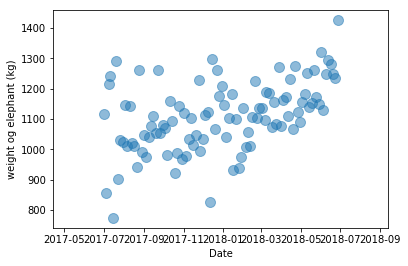

In [4]:
pyplot.scatter(ts,ys,alpha=0.5,s=100)
pyplot.xlabel("Date")
pyplot.ylabel("weight og elephant (kg)")

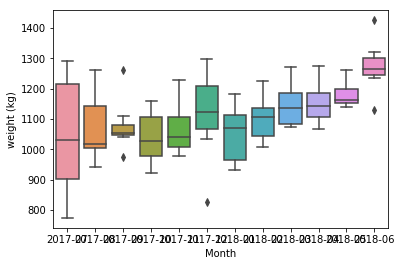

In [5]:
newDataFrame = pd.DataFrame({'x':xs,'t':ts,'weight (kg)': ys})
newDataFrame['Month'] = newDataFrame['t'].apply(lambda t: t.strftime('%Y-%m'))

sns.boxplot(data=newDataFrame, x='Month',y='weight (kg)')


confidence interval of the mean calculation can be computed by following eqn


$$\bar{x} \pm 1.96 \frac{\sigma}{\sqrt(n)}$$

the size of the confidence interval is inversely related to the square root of the number of samples. For instance, this is useful when you’re running an A/B test – if you want to detect a 1% difference then you need something on the order of 
$$0.01^{-2}$$ = 10,000 samples. and 1.96 denotes the 95% of the probability distribution.

Note:- 
the above formulation for identifying the mean only works when data is normally distributed. and by central limit theorem a random sampling of data follows normal distribution when sampled data is large enough.


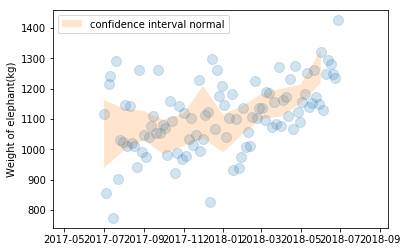

In [6]:
def plot_confidence_interval(observation_by_group):
    groups = list(sorted(observation_by_group.keys()))
    loBound = []
    upBound = []
    for group in groups:
        series = observation_by_group[group]
        mu,std,n = np.mean(series),np.std(series),len(series)
        loBound.append(mu-1.96*std*(n**(-0.5)))
        upBound.append(mu+1.96*std*(n**(-0.5)))
    pyplot.fill_between(groups,loBound,upBound,alpha = 0.2,label = 'confidence interval normal')

## plotting the scatter data point and the confidence interval
pyplot.scatter(ts,ys,alpha = 0.2,s=100)
observationByMonth = {}

for month,y in zip(newDataFrame['Month'],newDataFrame['weight (kg)']):
    observationByMonth.setdefault(month,[]).append(y)
plot_confidence_interval(observationByMonth)
pyplot.ylabel('Weight of elephant(kg)')
pyplot.legend()


## genereating the confidence of mean estimation using bootstrapping

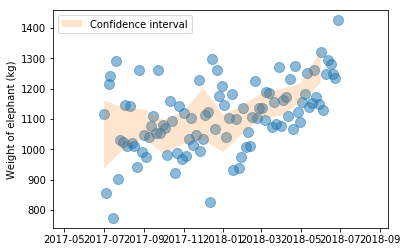

In [7]:
lo_bound = []
up_bound = []

months = sorted(observationByMonth.keys())

for month in months:
    series = observationByMonth[month]
    bootstrapped_means = []
    for i in range(10000):
        ## taking sample with replacment
        bootstrap = [random.choice(series) for _ in series] ## random.choice randomly select an element from the list and we run it for len of series list
        bootstrapped_means.append(np.mean(bootstrap))
    lo_bound.append(np.percentile(bootstrapped_means,2.5))
    up_bound.append(np.percentile(bootstrapped_means,97.5))
pyplot.scatter(ts, ys, alpha=0.5, s=100)
pyplot.fill_between(months, lo_bound, up_bound, alpha=0.2,
                    label='Confidence interval')
pyplot.ylabel('Weight of elephant (kg)')
pyplot.legend()

** Be aware though that there’s a danger zone of bootstrapping. My understanding is that bootstrapping will converge towards the correct estimates as the number of samples goes to infinity, but if you’re working with small samples, you can get really wonky results. I generally never trust bootstrapping for anything less than say 50 samples, and you probably shouldn’t do that either.
**

As a side note, Seaborn’s barplot actually plots confidence intervals using bootstrapping:

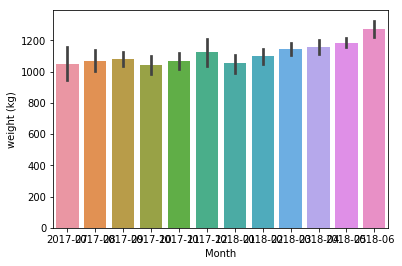

In [8]:
sns.barplot(data=newDataFrame, x='Month',y='weight (kg)')

# confidence interval when all outcome is 0 or 1

In [9]:
STATES = ['JH','KR','OR','TN']
GROUPS = ['test','control']

In [10]:
def genereate_binary_categorical(states=STATES,groups=GROUPS,k=400,zs = [0,0.2],z_std =0.01,b =-3,b_std=1):
    output = {}
    eObsPerState = np.random.exponential(k,size=len(states))
    stateBias = np.random.normal(b,b_std,size = len(states))
    for group,z in zip(groups,zs):
        noise = np.random.normal(z,z_std,size = len(states))
        ps = 1/(1+np.exp(-(noise+stateBias)))
        ns = np.random.poisson(eObsPerState)
#         print(ps,ns)
        ks = np.random.binomial(ns,ps)
        output[group] = (ns,ks)
    return output



{'test': (array([ 38, 470, 390, 153]), array([ 5, 46, 51,  3])), 'control': (array([ 34, 455, 377, 144]), array([ 5, 63, 57,  6]))}
data :  test
ns  [ 38 470 390 153]
ks :  [ 5 46 51  3]
data :  control
ns  [ 34 455 377 144]
ks :  [ 5 63 57  6]


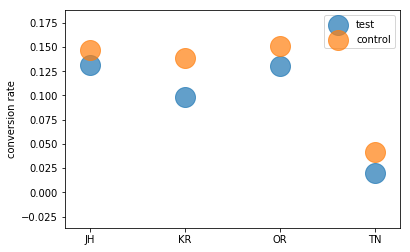

In [11]:
data = genereate_binary_categorical()
print (data)
for d, (ns,ks) in data.items():
    print ("data : ",d)
    print ("ns ",ns)
    print ("ks : ",ks)
    pyplot.scatter(STATES,ks/ns,label = d, alpha = 0.7,s = 400)
pyplot.ylabel('conversion rate')
pyplot.legend()

Since all outcomes are 0 or 1, and drawn with the same (unknown) probability, we know that the number of ones and zeros follows a binomial distribution. This means that the confidence interval of a “
k
 out of 
n
” scenario is a Beta distribution.

I’ve personally benefitted from memorizing the formula for the confidence interval and think I probably use it more than the previous (Normal based) one. In particular all you need to remember is

n, k = 100, 3

scipy.stats.beta.ppf([0.025, 0.975], k, n-k)

array([0.00629335, 0.07107612])


This will compute a 95% confidence interval if you plug in values for 
n and k. 
In this case we see that if we have 100 website visitors and 3 of them purchased the product, then range is 0.6%-7.1%

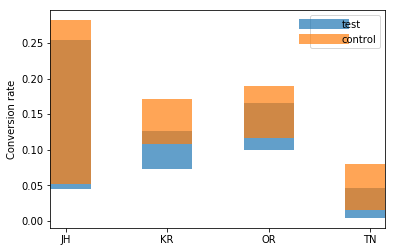

In [12]:
for group, (ns, ks) in data.items():
    lo = scipy.stats.beta.ppf(0.025, ks, ns-ks)
    hi = scipy.stats.beta.ppf(0.975, ks, ns-ks)
    mean = ks/ns
    pyplot.errorbar(STATES, y=mean, yerr=[mean-lo, hi-mean],
                    label=group, alpha=0.7, linewidth=0, elinewidth=50)

pyplot.ylabel('Conversion rate')
pyplot.legend()

# Linear regression

Text(0,0.5,'Weight of elephant (kg)')

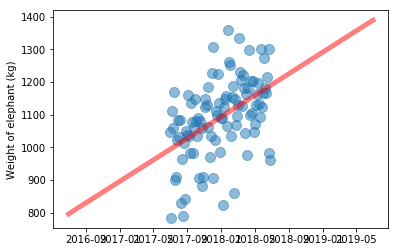

In [13]:
xs,ys,ts,x_scale,t_scale = genereate_time_series()


def model(xs,k,m):
    ## model definition
    return k*xs+m

def l2Loss(tup,xs,ys):
    ## return the loss output 
    k,m = tup
    delta = model(xs,k,m)-ys
    return np.dot(delta,delta)

k_hat,m_hat = scipy.optimize.minimize(l2Loss,(0,0),args=(xs,ys)).x  
pyplot.scatter(ts, ys, alpha=0.5, s=100)
pyplot.plot(t_scale, model(x_scale, k_hat, m_hat), color='red',
            linewidth=5, alpha=0.5)
pyplot.ylabel('Weight of elephant (kg)')

We just fit k and m but there’s no uncertainty estimates here. There’s several things we could estimate uncertainties for, but let’s start with the uncertainty of the predicted values.

We can do that by fitting a normal distribution around the line at the same time as we’re fitting k and m
. I’m going to do this using Maximum Likelihood. If you’re not familiar with this method, don’t be scared! If there’s any method in statistics that I’ve found as easily accessible (it’s basic probability theory) and useful, it’s this method.

In fact, minimizing squared loss (which we just did, in the previous snippet) is actually a special case of maximum likelihood! Minimizing the squared loss is the same thing as maximizing the logarithm of the probability of all the data. This is usually called the “log likelihood”.

So we already have an expression to minimize the squared loss. If we make the variance an unknown variable 
σ^2
 we can fit that at the same time! The quantity we’re going to try to minimize now turns into
 
 $$\frac{n}{2}log2\pi\sigma^2 + \frac{1}{2\sigma^2}\sum((y-y\hat))^2$$


Text(0,0.5,'Weight of elephant (kg)')

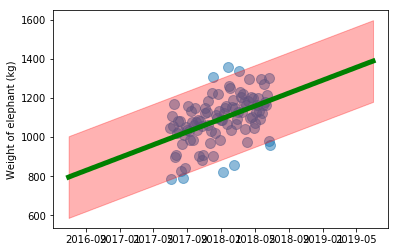

In [14]:
def negloglikelihood(tups,xs,ys):
    ## since sigma is >0 we are using log_sigma instead of sigma
    k,m,log_sigma = tups
    sigma = np.exp(log_sigma)
    delta = model(xs,k,m)-ys
    
    return (len(xs)/2)*np.log(2*np.pi*sigma**2) + \
            np.dot(delta,delta)/((2*sigma**2))

k_hat,m_hat,log_sigma = scipy.optimize.minimize(
    negloglikelihood, (0, 0, 0), args=(xs, ys)
).x
sigma_hat = np.exp(log_sigma)

pyplot.scatter(ts, ys, alpha=0.5, s=100)
pyplot.plot(t_scale, model(x_scale, k_hat, m_hat),
            color='green', linewidth=5)
pyplot.fill_between(
    t_scale,
    model(x_scale, k_hat, m_hat) - 1.96*sigma_hat,
    model(x_scale, k_hat, m_hat) + 1.96*sigma_hat,
    color='red', alpha=0.3)
# pyplot.legend()
pyplot.ylabel('Weight of elephant (kg)')
    

** note uncertinity here is not 100 % as it does not take into account the uncertinity in k , m and  σ **


## bootstrapping for uncertinity measure in regression

Text(0,0.5,'Weight of elephant (kg)')

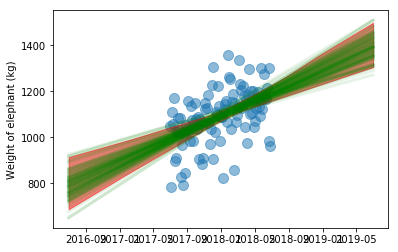

In [15]:
pyplot.scatter(ts,ys,alpha=0.5,s = 100)

xys = list(zip(xs,ys))
curves = []
for i in range(100):
    bootstrap = [random.choice(xys) for _ in xys]
    xs_bootstrap = np.array([x for x,y in bootstrap])
    ys_bootstrap = np.array([y for x,y in bootstrap])
    k_hat,m_hat = scipy.optimize.minimize(l2Loss,(0,0),args=(xs_bootstrap,ys_bootstrap)).x
    curves.append(model(x_scale,k_hat,m_hat))
for curve in curves:
    pyplot.plot(t_scale, curve, alpha=0.1, linewidth=3, color='green')
    
# Plot 95% confidence interval
lo, hi = np.percentile(curves, (2.5, 97.5), axis=0)
pyplot.fill_between(t_scale, lo, hi, color='red', alpha=0.5)
pyplot.ylabel('Weight of elephant (kg)')
    
    

*The first plot finds one solution of k and  m and shows the uncertainty of the predictions. So, if you’re asked what’s the range of the elephant’s weight in the next month, you can get it from the chart.*

*The second plot finds many solutions of k and m, and shows the uncertainty of kx+m. So this answers a different question – what’s the trend of the elephant’s weight over time and what’s the uncertainty of the trend.*

## using both of the approach together


Text(0,0.5,'Weight of elephant (kg)')

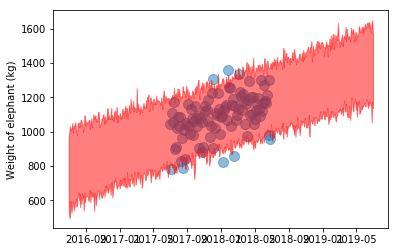

In [16]:
pyplot.scatter(ts,ys,alpha=0.5,s = 100)

xys = list(zip(xs,ys))
curves = []
for i in range(100):
    bootstrap = [random.choice(xys) for _ in xys]
    xs_bootstrap = np.array([x for x,y in bootstrap])
    ys_bootstrap = np.array([y for x,y in bootstrap])
    k_hat,m_hat,log_sigma_hat = scipy.optimize.minimize(negloglikelihood,(0,0,0),args=(xs_bootstrap,ys_bootstrap)).x
    curves.append(model(x_scale,k_hat,m_hat)+np.exp(log_sigma_hat)*np.random.normal(size=x_scale.shape))
    
# for curve in curves:
#     pyplot.plot(t_scale, curve, alpha=0.1, linewidth=3, color='green')
    
# Plot 95% confidence interval
lo, hi = np.percentile(curves, (2.5, 97.5), axis=0)
pyplot.fill_between(t_scale, lo, hi, color='red', alpha=0.5)
pyplot.ylabel('Weight of elephant (kg)')

# MCMC based optimization for the code 


Text(0,0.5,'Weigh of elephant (kg)')

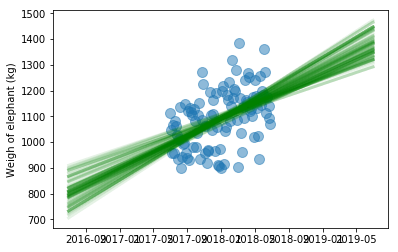

In [18]:
import emcee 
xs,ys,ts,x_scale,t_scale = genereate_time_series()

def logLikelihood(tups,xs,ys):
    return -negloglikelihood(tups,xs,ys)

ndims, nwalkers = 3, 10
p0  = [np.random.random(ndims) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers,ndims,logLikelihood,args = [xs,ys])
sampler.run_mcmc(p0,10000)

samples = sampler.chain[:, -10:, :].reshape((-1, ndims))

pyplot.scatter(ts, ys, alpha=0.5, s=100)
for k, m, log_sigma in samples:
    pyplot.plot(t_scale, model(x_scale, k, m), alpha=0.1,
                linewidth=3, color='green')
pyplot.ylabel('Weigh of elephant (kg)')

C:\Users\kumar\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\kumar\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\kumar\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


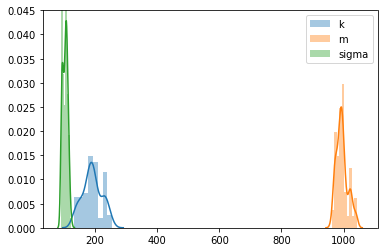

In [20]:
k_samples, m_samples, log_sigma_samples = samples.T
sns.distplot(k_samples, label='k')
sns.distplot(m_samples, label='m')
sns.distplot(np.exp(log_sigma_samples), label='sigma')
pyplot.legend()

Text(0,0.5,'Weight of elephant (kg)')

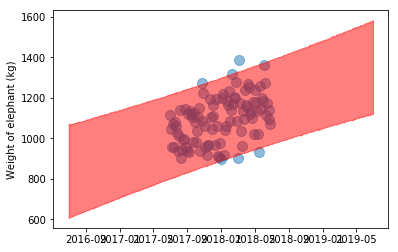

In [27]:
pyplot.scatter(ts,ys,alpha = 0.5,s = 100)
samples = sampler.chain[:,-4000:,:].reshape((-1,ndims))

curves = []

for k, m, log_sigma in samples:
    curves.append(
        model(x_scale, k, m) +
        np.exp(log_sigma) * np.random.normal(size=x_scale.shape)
    )

# Plot 95% confidence interval
lo, hi = np.percentile(curves, (2.5, 97.5), axis=0)
pyplot.fill_between(t_scale, lo, hi, color='red', alpha=0.5)
pyplot.ylabel('Weight of elephant (kg)')